In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets, append_axes, markers
import vice
vice.yields.ccsne.settings['o'] = 0.01
vice.yields.sneia.settings['o'] = 0
vice.yields.ccsne.settings['fe'] = 0.0008
vice.yields.sneia.settings['fe'] = 0.0011
from scipy.stats import multivariate_normal
import numpy as np
import math as m
import sys
sys.path.append("..")
from src.utils import exponential, chisquared, double_gaussian
from sgrfit import gaussian_SFE_burst
load_mpl_presets()
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)


In [2]:
raw = np.genfromtxt("../data/sgr/sgrchem.dat")
data = vice.dataframe({})
data["[fe/h]"] = raw[:, 0]
data["[fe/h]_err"] = raw[:, 1]
data["[o/fe]"] = raw[:, 2]
data["[o/fe]_err"] = raw[:, 3]
# data = data.filter("[o/fe]", "<=", 0.35)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: tau_star
  warnings.warn("""\


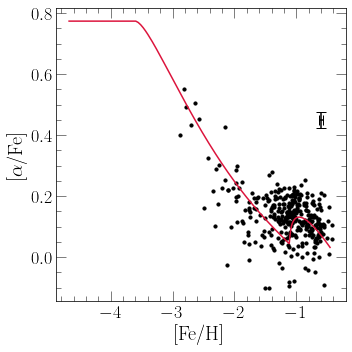

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
# ax.set_xlim([-3.2, -0.2])
# ax.set_ylim([-0.2, 0.6])
# ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6])

# kwargs = {
#     "c": named_colors()["black"],
#     "linestyle": "None",
#     "xerr": data["[fe/h]_err"],
#     "yerr": data["[o/fe]_err"]
# }
# ax.errorbar(data["[fe/h]"], data["[o/fe]"], **kwargs)

kwargs = {
    "c": named_colors()["black"],
    "s": 10
}
ax.scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)

med_feh_err = np.median(data["[fe/h]_err"])
med_ofe_err = np.median(data["[o/fe]_err"])
ax.errorbar(-0.6, 0.45, xerr = med_feh_err, yerr = med_ofe_err,
    c = named_colors()["black"])

def ifr(t):
    return t * np.exp(-t / 0.93)

def tstar(t):
    onset = 8.80
    rampup = 0.08
    top = 176.74
    bottom = 22.98
    if t < onset:
        return top
    elif onset <= t <= onset + rampup:
        return top - (top - bottom) / rampup * (t - onset)
    else:
        return bottom

with vice.singlezone(name = "sgrtest") as sz:
    vice.yields.ccsne.settings['fe'] = 0.00038
    vice.yields.sneia.settings['fe'] = 0.00224
    duration = 12.75
    sz.mode = "ifr"
    sz.func = ifr
    sz.tau_star = tstar
    sz.eta = 5.78
    sz.dt = duration / 1000
    bfout = sz.run(np.linspace(0, duration, 1001), overwrite = True, capture = True)
    ax.plot(bfout.history["[fe/h]"], bfout.history["[o/fe]"], c = named_colors()["crimson"])

plt.tight_layout()
plt.show()

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: tau_star
  warnings.warn("""\


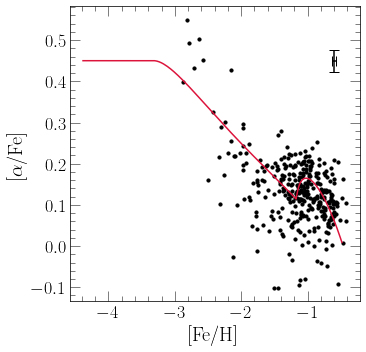

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
# ax.set_xlim([-3.2, -0.2])
# ax.set_ylim([-0.2, 0.6])
# ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6])

# kwargs = {
#     "c": named_colors()["black"],
#     "linestyle": "None",
#     "xerr": data["[fe/h]_err"],
#     "yerr": data["[o/fe]_err"]
# }
# ax.errorbar(data["[fe/h]"], data["[o/fe]"], **kwargs)

kwargs = {
    "c": named_colors()["black"],
    "s": 10
}
ax.scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)

med_feh_err = np.median(data["[fe/h]_err"])
med_ofe_err = np.median(data["[o/fe]_err"])
ax.errorbar(-0.6, 0.45, xerr = med_feh_err, yerr = med_ofe_err,
    c = named_colors()["black"])

# def ifr(t):
#     return t * np.exp(-t / 0.01)

# def tstar(t):
#     onset = 9.83
#     rampup = 0.09
#     top = 197.34
#     bottom = 22.68
#     if t < onset:
#         return top
#     elif onset <= t <= onset + rampup:
#         return top - (top - bottom) / rampup * (t - onset)
#     else:
#         return bottom

with vice.singlezone(name = "sgrtest") as sz:
    vice.yields.ccsne.settings['fe'] = 0.0008
    vice.yields.sneia.settings['fe'] = 0.0011
    duration = 13.2
    sz.mode = "sfr"
    sz.func = double_gaussian()
    sz.func.first.amplitude = 100
    sz.func.first.mean = 12.91
    sz.func.first.width = 1.47
    sz.func.second.amplitude = 92
    sz.func.second.mean = 4.23
    sz.func.second.width = 4.07
    sz.eta = 15.12
    sz.tau_star = gaussian_SFE_burst()
    sz.tau_star.constant = 172.21
    sz.tau_star.amplitude = 0.93
    sz.tau_star.mean = 9.50
    sz.tau_star.width
    sz.dt = duration / 1000
    bfout = sz.run(np.linspace(0, duration, 1001), overwrite = True, capture = True)
    ax.plot(bfout.history["[fe/h]"], bfout.history["[o/fe]"], c = named_colors()["crimson"])

plt.tight_layout()
plt.show()

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: tau_star
  warnings.warn("""\


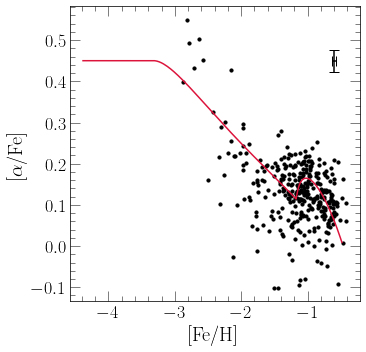

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
# ax.set_xlim([-3.2, -0.2])
# ax.set_ylim([-0.2, 0.6])
# ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6])

# kwargs = {
#     "c": named_colors()["black"],
#     "linestyle": "None",
#     "xerr": data["[fe/h]_err"],
#     "yerr": data["[o/fe]_err"]
# }
# ax.errorbar(data["[fe/h]"], data["[o/fe]"], **kwargs)

kwargs = {
    "c": named_colors()["black"],
    "s": 10
}
ax.scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)

med_feh_err = np.median(data["[fe/h]_err"])
med_ofe_err = np.median(data["[o/fe]_err"])
ax.errorbar(-0.6, 0.45, xerr = med_feh_err, yerr = med_ofe_err,
    c = named_colors()["black"])

def ifr(t):
    return t * np.exp(-t / 0.01)

def tstar(t):
    onset = 9.83
    rampup = 0.09
    top = 197.34
    bottom = 22.68
    if t < onset:
        return top
    elif onset <= t <= onset + rampup:
        return top - (top - bottom) / rampup * (t - onset)
    else:
        return bottom

with vice.singlezone(name = "sgrtest") as sz:
    vice.yields.ccsne.settings['fe'] = 0.0008
    vice.yields.sneia.settings['fe'] = 0.0011
    duration = 13.2
    sz.mode = "ifr"
#     sz.func = ifr
    sz.func = 
    sz.tau_star = tstar
    sz.eta = 19.35
    sz.dt = duration / 1000
    bfout = sz.run(np.linspace(0, duration, 1001), overwrite = True, capture = True)
    ax.plot(bfout.history["[fe/h]"], bfout.history["[o/fe]"], c = named_colors()["crimson"])

plt.tight_layout()
plt.show()

In [5]:
quantities = list(filter(lambda _: not _.endswith("_err"), data.keys()))
sample = np.array([data[key] for key in quantities]).T
errors = np.array([data["%s_err" % (key)] for key in quantities]).T
model = len(bfout.history["time"]) * [None]
for i in range(len(model)):
    model[i] = len(quantities) * [0.]
    for j in range(len(quantities)):
        # no age information in the Sgr data (all distant giants)
        model[i][j] = bfout.history[quantities[j]][i]
model = model[1:] # chop off the -inf [Fe/H] predicted at t = 0
weights = bfout.history["sfr"][1:]
chisq = chisquared(sample, errors, model, weights)
print(chisq / (len(quantities) * len(sample) - 7))

4.457055084876451


$\chi_\text{dof}^2 = 5.367$ with the Fe yields as free parameters

$\chi_\text{dof}^2 = 4.457$ with the Fe yields fixed at $y_\text{Fe}^\text{CC} = 0.0008$ and $y_\text{Fe}^\text{Ia} = 0.0011$

Neither are a good fit. This probably suggests that the functional forms I've taken for the Sgr dSph's evolution are not accurate characterizations of its evolution.

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: tau_star
  warnings.warn("""\
/var/folders/1p/lm_h7y810f9_7ygnvr2tjc_w0000gn/T/ipykernel_609/1191136824.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


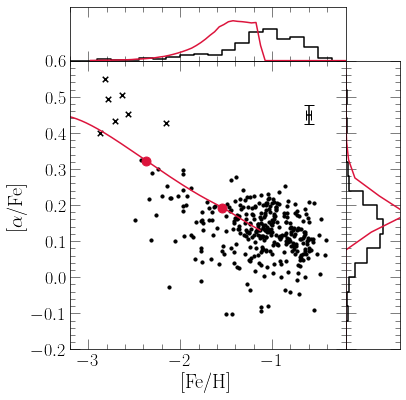

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
ax.set_xlim([-3.2, -0.2])
ax.set_ylim([-0.2, 0.6])
top = fig.add_axes([0.1, 0.9, 0.8, 0.1])
right = fig.add_axes([0.9, 0.1, 0.1, 0.8])
plt.setp(top.get_xticklabels(), visible = False)
plt.setp(top.get_yticklabels(), visible = False)
plt.setp(right.get_xticklabels(), visible = False)
plt.setp(right.get_yticklabels(), visible = False)
top.set_ylim([0, 2.0])
top.tick_params(axis = "y", which = "both", left = False, right = False)
right.set_xlim([0, 8])
right.tick_params(axis = "x", which = "both", bottom = False, top = False)

sub = data.filter("[o/fe]", "<=", 0.35)
kwargs = {
    "c": named_colors()["black"],
    "s": 10
}
ax.scatter(sub["[fe/h]"], sub["[o/fe]"], **kwargs)

sub = data.filter("[o/fe]", ">=", 0.35)
kwargs["marker"] = markers()["x"]
kwargs["s"] = 30
ax.scatter(sub["[fe/h]"], sub["[o/fe]"], **kwargs)

med_feh_err = np.median(data["[fe/h]_err"])
med_ofe_err = np.median(data["[o/fe]_err"])
ax.errorbar(-0.6, 0.45, xerr = med_feh_err, yerr = med_ofe_err,
    c = named_colors()["black"])

feh_dist, feh_bins = np.histogram(data["[fe/h]"],
    bins = 20, range = ax.get_xlim(), density = True)
ofe_dist, ofe_bins = np.histogram(data["[o/fe]"],
    bins = 20, range = ax.get_ylim(), density = True)
top.step(feh_bins[:-1], feh_dist, where = "post", c = named_colors()["black"])
right.step(ofe_dist, ofe_bins[:-1], where = "pre", c = named_colors()["black"])

bf_duration = 12.94
with vice.singlezone(name = "./sgr") as sz:
    sz.func = double_gaussian()
    sz.func.first.amplitude = 100
    sz.func.first.mean = 1.42
    sz.func.first.width = 4.57
    sz.func.second.amplitude = 100 * 0.31
    sz.func.second.mean = 7.07
    sz.func.second.width = 1.82
    sz.eta = 10.82
    sz.tau_star = gaussian_SFE_burst()
    sz.tau_star.constant = 140.94
    sz.tau_star.amplitude = 0.14
    sz.tau_star.mean = sz.func.second.mean
    sz.tau_star.width = sz.func.second.width
    sz.dt = bf_duration / 1000
    bfout = sz.run(np.linspace(0, bf_duration, 1001), overwrite = True, capture = True)
    
kwargs = {"c": named_colors()["crimson"]}
ax.plot(bfout.history["[fe/h]"], bfout.history["[o/fe]"], **kwargs)
bin_centers = [(a + b) / 2 for a, b in zip(bfout.mdf["bin_edge_left"],
    bfout.mdf["bin_edge_right"])]
top.plot(bin_centers, bfout.mdf["dn/d[fe/h]"], **kwargs)
right.plot(bfout.mdf["dn/d[o/fe]"], bin_centers, **kwargs)

diff = [abs(_ - sz.func.first.mean) for _ in bfout.history["time"]]
idx = diff.index(min(diff))
# kwargs["marker"] = markers()["x"]
kwargs["s"] = 80
ax.scatter(bfout.history["[fe/h]"][idx], bfout.history["[o/fe]"][idx], **kwargs)

diff = [abs(_ - sz.func.second.mean) for _ in bfout.history["time"]]
idx = diff.index(min(diff))
ax.scatter(bfout.history["[fe/h]"][idx], bfout.history["[o/fe]"][idx], **kwargs)

top.set_xlim(ax.get_xlim())
right.set_ylim(ax.get_ylim())
plt.tight_layout()
top.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.15
])
right.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.15,
    ax.get_position().y1 - ax.get_position().y0
])
plt.show()

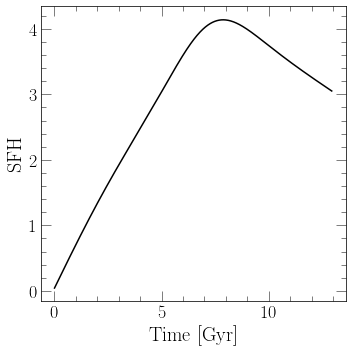

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Time [Gyr]")
ax.set_ylabel("SFH")
ax.plot(bfout.history["time"], bfout.history["sfr"], c = named_colors()["black"])
plt.tight_layout()
plt.show()